# Setup

In [42]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [43]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 5)
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
plt.rcParams['figure.figsize'] = [16, 5]
pal = plt.get_cmap('Paired').colors

import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('notebook')



from tqdm import tqdm, tqdm_notebook
import quandl

In [44]:
from utils import *

In [45]:
# api_key = open(file='quandl_api').read().replace('\n', '')
# quandl.ApiConfig.api_key = api_key

# tickers, prices = get_quandl_sharadar(free=True)
# prices = prices.assign(Set='free')

tickers, prices = get_sharadar_train()
prices = prices.query('Set == "train"')

In [46]:
print(len(tickers), 'assets in train set.')
prices

9010 assets in train set.


Open    High    Low  Close      Volume  Dividends  \
Ticker Date                                                             
A      1999-11-18  45.50  50.000  40.00  44.00  44739900.0        0.0   
       1999-11-19  42.94  43.000  39.81  40.38  10897100.0        0.0   
...                  ...     ...    ...    ...         ...        ...   
ZYNE   2017-08-17   6.36   6.639   6.20   6.32    651837.0        0.0   
       2017-08-18   6.26   6.450   6.17   6.25    423696.0        0.0   

                   Closeunadj Lastupdated    Set  
Ticker Date                                       
A      1999-11-18       44.00  2018-02-11  train  
       1999-11-19       40.38  2018-02-11  train  
...                       ...         ...    ...  
ZYNE   2017-08-17        6.32  2017-11-01  train  
       2017-08-18        6.25  2017-11-01  train  

[14052292 rows x 9 columns]

In [47]:
ticker_days = prices.groupby('Ticker')[['Set']].count().rename(columns={'Set': 'n_days'}).reset_index()

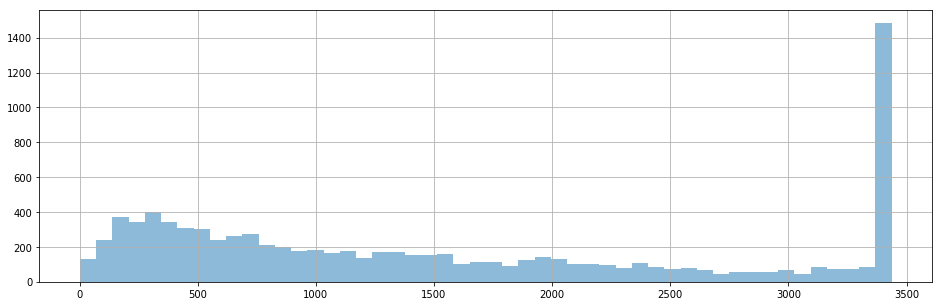

In [48]:
ticker_days.n_days.hist(bins=50, alpha=0.5)

# Finding the trend in a single price

See An introduction to smoothing time series in python, [part 1](http://www.nehalemlabs.net/prototype/blog/2013/04/05/an-introduction-to-smoothing-time-series-in-python-part-i-filtering-theory/) and [part 2](http://www.nehalemlabs.net/prototype/blog/2013/04/09/an-introduction-to-smoothing-time-series-in-python-part-ii-wiener-filter-and-smoothing-splines/).

Series to check:

* AKTC

In [ ]:
ticker = np.random.choice(tickers)
price = prices.loc[ticker]
print(len(price), 'days.')
price[['Open', 'High', 'Low', 'Close']].plot()
plt.title(ticker);

## Filters

In [ ]:
from scipy.interpolate import UnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
import scipy.optimize as op

### Linear 

In [ ]:
N = 61
f_sma = np.ones(N) / N

### Gaussian

In [ ]:
N_ga = 1500
f_ga = gaussian(N_ga, std=30.)
f_ga = f_ga / f_ga.sum()

In [ ]:
plt.figure(figsize=(7, 3))
plt.axhline(c='grey')
plt.axvline(c='grey')
plt.plot(np.arange(-N/2, N/2), f_sma, label='f_sma')
plt.plot(np.arange(-N_ga/2, N_ga/2), f_ga, label='f_ga')
plt.show()

### Geometric

In [ ]:
f_geo = lambda s: np.exp(filters.convolve1d(np.log(price.Close), f_ga))

### Wiener 

In [ ]:
sigma = np.std(price.Close)
f_wi = lambda x: wiener(x, mysize=N, noise=sigma)

### Spline

In [ ]:
f_sp = lambda x: UnivariateSpline(np.arange(len(x)), x)(np.arange(len(x)))

### Results

In [ ]:
plt.figure(figsize=(16, 6))
results = price[['Close']].assign(
    sma=filters.convolve1d(price.Close, f_sma),
    geo=f_geo(price.Close),
    ga=filters.convolve1d(price.Close, f_ga),
    ga2=filters.convolve1d(filters.convolve1d(price.Close, f_ga), f_ga),
    wi=f_wi(price.Close),
    sp=f_sp(price.Close),
)
results[:1000].plot(alpha=0.5);

In [ ]:
plt.figure(figsize=(16, 6));
results.plot(alpha = 0.5);

In [ ]:
def smooth_price(df, N=151, std=20.):
    f_ga = gaussian(N_ga, std=std)
    f_ga = f_ga / f_ga.sum()
    df = df.assign(Smoothed=filters.convolve1d(df.Close, f_ga))
    
    return df

## Trends 

### Peaks and Valleys

In [ ]:
from scipy.signal import find_peaks, find_peaks_cwt
from sklearn.metrics import confusion_matrix

In [ ]:
results = smooth_price(price)

In [ ]:
results

In [ ]:
results = results.assign(Trend=np.nan, Max_Drawdown=np.nan)
peaks, _ = find_peaks(results.Smoothed)
valleys, _ = find_peaks(-results.Smoothed)

In [ ]:
n_changes = min(len(peaks), len(valleys))
assert len(set(np.sign(peaks[:n_changes] - valleys[:n_changes]))) == 1

In [ ]:
# End
if valleys.max() > peaks.max():
    peaks = np.concatenate((peaks, np.ones(1, dtype=np.int32) * len(results) - 1))
else:
    valleys = np.concatenate((valleys, np.ones(1, dtype=np.int32) * len(results) - 1))

In [ ]:
peaks

In [ ]:
results.loc[results.index[peaks], 'Trend'] = 1
results.loc[results.index[valleys], 'Trend'] = -1
results.Trend.fillna(method='bfill', inplace=True)

In [ ]:
results

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend up')
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend down')
plt.plot(results['Close'], alpha = 0.5)
plt.plot(results['Smoothed'], alpha = 0.5)
plt.plot(results.iloc[peaks]['Smoothed'], 'o', label='peaks')
plt.plot(results.iloc[valleys]['Smoothed'], 'o', label='valleys')
plt.axhline(0, c='grey')
plt.show()

### Slopes

In [ ]:
results = results.assign(Trend2=results.Smoothed.pct_change().apply(np.sign))
results.loc[results.index[0], 'Trend2'] = results.Trend2[1]

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend2.max(), where= results.Trend2 > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend2 up')
ax.fill_between(results.index, 0, results.Trend2.max(), where= results.Trend2 < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend2 down')
plt.plot(results['Close'], alpha = 0.5)
plt.plot(results['Smoothed'], alpha = 0.5)
plt.plot(results.iloc[peaks]['Smoothed'], 'o', label='peaks')
plt.plot(results.iloc[valleys]['Smoothed'], 'o', label='valleys')
plt.axhline(0, c='grey')
plt.show()

In [ ]:
confusion_matrix(results.Trend.values, results.Trend2) / len(results)

> Both methods are equivalent!!

## Max drawdown within trend

-> For trailing stop-loss orders...

In [ ]:
breakpoints = np.concatenate((np.zeros(1, dtype=np.int32), peaks + 1, valleys + 1))
breakpoints.sort()
print('Breakpoints:', breakpoints)

In [ ]:
b = 3
trend_start = breakpoints[b - 1]
trend_end = breakpoints[b]
res_b = results[trend_start:trend_end]
res_b

In [ ]:
for b in range(1, len(breakpoints)):

    trend_start = breakpoints[b - 1]
    trend_end = breakpoints[b]
    res_b = results[trend_start:trend_end]
    trend_b = res_b.Trend[0]

    # Adjust for position (long, short)
    close_b = res_b.Close[0] * res_b.Close.pct_change()[1:].mul(trend_b).add(1).cumprod()  
    close_b[res_b.index[0]] = res_b.Close[0]
    close_b = close_b.sort_index()

    peak = close_b[0]
    low = peak
    drawdown = 0
    max_drawdown = 0

    for i in range(1, len(close_b)):
        # Max drawdown
        if close_b[i] > peak:
            peak = close_b[i]
            low = peak
        if close_b[i] < low:
            low = close_b[i]
            drawdown = low / peak - 1
        max_drawdown = min(drawdown, max_drawdown)
    
    results.loc[res_b.index, 'Max_Drawdown'] = -max_drawdown
    

In [ ]:
results

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend up')
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend down')
plt.plot(results.Close, label='Close')
plt.plot(results.Smoothed, label='Smoothed')
plt.plot(results.Close * (1 - results.Max_Drawdown * results.Trend), label='Stop-loss')
plt.axhline(0, c='grey')
plt.legend()
plt.title(ticker)
plt.show()

In [ ]:
res2 = find_trends(price)
plot_trends(res2)

# Sample...

## A single asset 

In [ ]:
from utils import *

In [ ]:
ticker = np.random.choice(tickers)
# ticker = 'TFCO'
price = prices.loc[ticker]
print(len(price), 'days.')

In [ ]:
trends = find_trends(price, sd=20.)
plot_trends(trends, ticker)

In [ ]:
trends

In [ ]:
trends.groupby('n_Trend').first()

In [ ]:
trends.groupby('n_Trend').Trend.count()

In [ ]:
summarise_trends(price, sd=20)

In [ ]:
trends2 = find_trends(price, sd=5.)
plot_trends(trends2, ticker)

In [ ]:
summarise_trends(price, sd=5)

In [ ]:
sds = np.arange(5, 250, step=5)
sum_trends = pd.concat([summarise_trends(price, s) for s in sds], axis=0)

In [ ]:
sum_trends

In [ ]:
sum_trends.set_index('sd')[['mean', 'min', '50%', 'max']].plot();

In [ ]:
sum_trends.set_index('sd')[['trend_freq']].plot();

In [ ]:
sum_trends.set_index('sd')[['ICAGR', 'mean_ICAGR', 'neg_ICAGR']].plot();

In [ ]:
sum_trends.set_index('sd')[['Bliss']].plot();

## Multiple assets

### Single thread

In [ ]:
from utils import *
# summarise_trends(prices.loc['A'], sd=100)
# results = pickle.load(open('output/Finding the trends - sd values for filtering.pickle', 'rb'))

In [ ]:
# n_tickers = 1000
sds = np.arange(5, 300, step=5)

results = []
# grouped = prices.loc[np.random.choice(tickers, size=n_tickers)].groupby('Ticker')
grouped = prices.groupby('Ticker')
# grouped = prices.loc[list(set(results_df.Ticker.values))].groupby('Ticker')

for name, group in tqdm_notebook(grouped, desc='Ticker:'):
    res_g = []
    for s in tqdm_notebook(sds, desc='sd:', leave=False, postfix=dict(n_days=str(len(group)))):
        try:
            res_g.append(summarise_trends(group.reset_index('Ticker'), s))
        except:
            pass
    try:
        results.append(pd.concat(res_g, axis=0).assign(Ticker=name))
    except:
        pass

In [ ]:
# pickle.dump(results, open('output/Finding the trends - std values for filtering.pickle', 'wb'))

### Results

In [67]:
results = pickle.load(open('output/Finding the trends - std values for filtering.pickle', 'rb'))

In [68]:
results_df = pd.concat(results, axis=0, sort=True)
# results_df = results_df.query('n_days > 3 * sd')
results_df = results_df.set_index('Ticker').loc[np.random.choice(results_df.Ticker.values, size=500)]
results_df = results_df.reset_index().query('n_days > 3 * sd')
results_df

,Ticker,25%,50%,75%,Bliss,ICAGR,Max_Drawdown,Ratio,count,max,mean,mean_Bliss,mean_ICAGR,min,n_days,neg_ICAGR,neg_freq,sd,std,trend_freq
0,GCOR,16.00,24.0,43.00,17.947266,2.333172,0.130002,2293.285316,29.0,89.0,28.655172,46.334248,2.695630,7.0,831,0,0.0,5,17.911042,12.711492
1,GCOR,24.25,32.5,46.25,7.784758,1.843758,0.236842,452.436356,22.0,89.0,37.772727,27.939108,1.992383,15.0,831,0,0.0,10,19.534906,9.643201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29498,BUCY,1228.00,1228.0,1228.00,2.212319,1.904896,0.861040,10976.666667,1.0,1228.0,1228.000000,2.212319,1.904896,1228.0,1228,0,0.0,290,NaN,0.296621
29499,BUCY,1228.00,1228.0,1228.00,2.212319,1.904896,0.861040,10976.666667,1.0,1228.0,1228.000000,2.212319,1.904896,1228.0,1228,0,0.0,295,NaN,0.296621


####  ICAGR

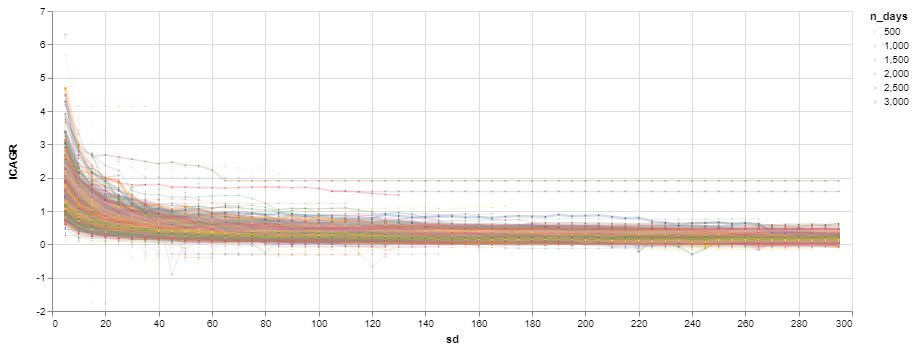

In [10]:
alt.Chart(results_df.reset_index()).mark_line(point=True, opacity=0.25).encode(
    x='sd',
    y='ICAGR',
    color=alt.Color('Ticker', legend=None),
    size='n_days',
    tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days', 'sd']
).properties(width=800, height=300).interactive()

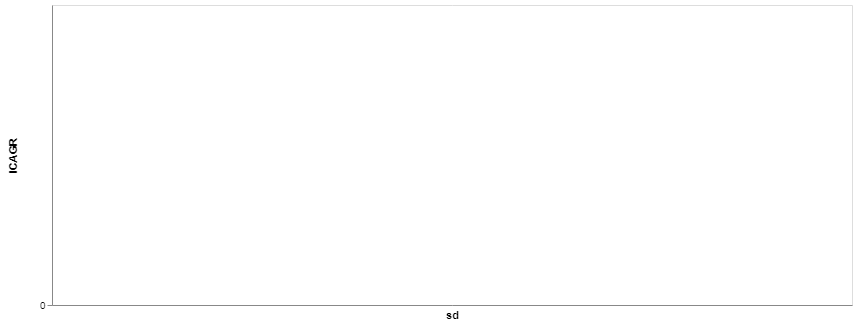

In [11]:
line = alt.Chart(results_df.reset_index()).mark_line().encode(
    x='sd',
    y='mean(ICAGR)'
)
confidence_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.5).encode(
    x='sd',
    y=alt.Y('ci0(ICAGR)', axis=alt.Axis(title='ICAGR')),
    y2='ci1(ICAGR)',
)
total_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.1).encode(
    x='sd',
    y=alt.Y('min(ICAGR)', axis=alt.Axis(title='ICAGR')),
    y2='max(ICAGR)',
).properties(width=800, height=300).interactive()
total_interval + confidence_interval + line

#### Max Drawdown

In [ ]:
alt.Chart(results_df.reset_index()).mark_line(point=True, opacity=0.25).encode(
    x='sd',
    y='Max_Drawdown',
    color=alt.Color('Ticker', legend=None),
    size='n_days',
    tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days', 'sd']
).properties(width=800, height=300).interactive()

In [ ]:
line = alt.Chart(results_df.reset_index()).mark_line().encode(
    x='sd',
    y='mean(Max_Drawdown)'
).properties(width=800, height=300).interactive()
confidence_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.5).encode(
    x='sd',
    y=alt.Y('ci0(Max_Drawdown)', axis=alt.Axis(title='Max_Drawdown')),
    y2='ci1(Max_Drawdown)',
)
total_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.1).encode(
    x='sd',
    y=alt.Y('min(Max_Drawdown)', axis=alt.Axis(title='Max_Drawdown')),
    y2='max(Max_Drawdown)',
)
# total_interval + 
confidence_interval + line

#### Bliss

In [ ]:
alt.Chart(results_df.reset_index()).mark_line(point=True, opacity=0.5).encode(
    x='sd',
    y='Bliss',
    color=alt.Color('Ticker', legend=None),
    size='n_days',
    tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days']
).properties(
    width=800,
    height=300
).interactive()

In [ ]:
line = alt.Chart(results_df.reset_index()).mark_line().encode(
    x='sd',
    y='mean(Bliss)'
).properties(width=800, height=300).interactive()
confidence_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.5).encode(
    x='sd',
    y=alt.Y('ci0(Bliss)', axis=alt.Axis(title='Bliss')),
    y2='ci1(Bliss)',
)
total_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.1).encode(
    x='sd',
    y=alt.Y('min(Bliss)', axis=alt.Axis(title='Bliss')),
    y2='max(Bliss)',
)
# total_interval + 
confidence_interval + line

#### Error frequency

In [ ]:
line = alt.Chart(results_df.reset_index(), title='Number of negative ratios / number of trends').mark_line().encode(
    x='sd',
    y='mean(neg_freq)'
).properties(width=800, height=300).interactive()
confidence_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.5).encode(
    x='sd',
    y=alt.Y('ci0(neg_freq)', axis=alt.Axis(title='neg_freq')),
    y2='ci1(neg_freq)',
)
total_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.1).encode(
    x='sd',
    y=alt.Y('min(neg_freq)', axis=alt.Axis(title='neg_freq')),
    y2='max(neg_freq)',
)
# total_interval + 
confidence_interval + line

In [ ]:
alt.Chart(results_df.assign(Color = results_df.neg_ICAGR > 0).reset_index()).mark_area(opacity=0.25).encode(
    x='sd',
    y=alt.Y('count()'),
    color=alt.Color('Color', title='neg_ICAGR'),
#     size='sd',
#     tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days', 'sd', 'ICAGR', 'neg_ICAGR']
).properties(
    width=800,
    height=200
).interactive()

In [ ]:
alt.Chart(results_df.assign(neg_ICAGR = results_df.neg_ICAGR.astype(str)).reset_index()).mark_area(opacity=0.25).encode(
    x='sd',
    y=alt.Y('count()'),
    color=alt.Color('neg_ICAGR', title='neg_ICAGR',
                    scale=alt.Scale(domain=[str(i) for i in np.arange(11)])),
#     size='sd',
#     tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days', 'sd', 'ICAGR', 'neg_ICAGR']
).properties(
    width=800,
    height=200
).interactive()

#### Trend frequency and duration

In [ ]:
alt.Chart(results_df).mark_line(point=True, opacity=0.5).encode(
    x='sd',
    y=alt.Y('trend_freq', scale=alt.Scale(type='log')), #y='trend_freq',
    color=alt.Color('Ticker', legend=None),
    size='n_days',
    tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days']
).properties(
    width=800,
    height=200
).interactive()

In [ ]:
alt.Chart(results_df, title='Trend duration (days)').mark_line(point=True, opacity=0.5).encode(
    x='sd',
    y=alt.Y('mean', scale=alt.Scale(type='log')), #y='trend_freq',
    color=alt.Color('Ticker', legend=None),
    size='n_days',
    tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days']
).properties(
    width=800,
    height=200
).interactive()

#### Lab

In [ ]:
ticker = np.random.choice(results_df.Ticker)  
ticker = 'NSCT'
price = prices.loc[ticker]
print(ticker, len(price), 'days.')

In [ ]:
# price = price.query('Volume > 0')

In [ ]:
trends = find_trends(price, sd=20)
plot_trends(trends, ticker)

# Data transforms for learning

In [89]:
ticker = np.random.choice(tickers)
price = prices.loc[ticker]
print(ticker, len(price), 'days.')

TERN 1504 days.


In [115]:
df = price
tr = find_trends(df)
tr = tr[['Open', 'High', 'Low', 'Close', 'Volume', 'Set', 'Trend', 'Max_Drawdown', 'ICAGR']]
tr = tr.assign(Ch = tr.Close.pct_change().add(1).apply('log'))
tr = tr.assign(Ch2 = tr.Ch.pow(2), Ch3 = tr.Ch.pow(3), Ch4 = tr.Ch.pow(4))

In [117]:
tr

,Open,High,Low,Close,Volume,Set,Trend,Max_Drawdown,ICAGR,Ch,Ch2,Ch3,Ch4
Date,,,,,,,,,,,,,
1999-01-04,18.563,19.188,18.313,18.563,286702.0,train,-1.0,0.299283,1.096051,NaN,NaN,NaN,NaN
1999-01-05,18.625,19.188,18.250,18.438,187786.0,train,-1.0,NaN,NaN,-0.006757,0.000046,-3.084499e-07,2.084072e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-12-23,2.640,2.670,2.580,2.640,480300.0,train,1.0,NaN,NaN,0.015267,0.000233,3.558782e-06,5.433361e-08
2004-12-27,2.640,2.690,2.570,2.660,495302.0,train,1.0,NaN,NaN,0.007547,0.000057,4.298912e-07,3.244477e-09


In [ ]:
def transform_trends(df, sd=15):
    tr = find_trends(df, sd)
    tr = tr.loc

# TO DO:

* Asset selection.
  * By small or negative change correlations.
  * Highest signal to noise ratios (see Kaufman, 2005, pp. 870).
* Exit by volume (~extreme reduction, bankrupt, ...).
* Feature engineering.
  * c.f. fast.ai's `add_datepart` function.